Response time

In [3]:
"""IMPORTS
"""

import sys
sys.path.append("../DBL-Data-Challenge")
from database.connect import getConnection
import pandas as pd
import seaborn as sns
sns.set()
import random
import matplotlib.pyplot as plt
from globals import airlineIDs
import re

"""MODEL IMPORTS
""""""
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
#model.save_pretrained(MODEL)"""

'MODEL IMPORTS\n\nfrom transformers import AutoModelForSequenceClassification\nfrom transformers import TFAutoModelForSequenceClassification\nfrom transformers import AutoTokenizer, AutoConfig\nimport numpy as np\nfrom scipy.special import softmax\n# Preprocess text (username and link placeholders)\ndef preprocess(text):\n    new_text = []\n    for t in text.split(" "):\n        t = \'@user\' if t.startswith(\'@\') and len(t) > 1 else t\n        t = \'http\' if t.startswith(\'http\') else t\n        new_text.append(t)\n    return " ".join(new_text)\nMODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"\ntokenizer = AutoTokenizer.from_pretrained(MODEL)\nconfig = AutoConfig.from_pretrained(MODEL)\n# PT\nmodel = AutoModelForSequenceClassification.from_pretrained(MODEL)\n#model.save_pretrained(MODEL)'

In [4]:
import time
def execution_time(start_time):
    return ("--- %s seconds ---" % (time.time() - start_time))

In [5]:
try:
    connection1 = getConnection()
except Exception:
    print("✖️ Error while connecting to MySQL engine database.")
    print("ℹ️ Please make sure the environment file `.env` is located at"+
        "the project root directory and contains proper configuration.")
    raise

In [6]:
"""Loads all the relevant data, this takes ~10 min.
"""
# Keeps track of execution time
start_time = time.time()

# Connects to database
print(f'Connection successful! {execution_time(start_time)}')
cursor = connection1.cursor()

#print("The tweets are being queried")
#query="SELECT id, text, in_reply_to, timestamp, user_mentions, user_id FROM tweets"
#cursor.execute(query)

#print('The tweets are being fetched')
#texts = cursor.fetchall()
#number_tweets = cursor.rowcount
#print("Total number of rows in table: ", number_tweets)

# Index column is being added
#print("Index is being added")
query= "DROP TABLE tweets_with_index"
cursor.execute(query)

# Create new table will the relevant data
#print(f'Table with index is being created {execution_time(start_time)} ')
query= "CREATE TABLE tweets_with_index SELECT ROW_NUMBER() OVER() AS row_num, id, text, in_reply_to_status_id, timestamp_ms, mentions, user_id, sentiment FROM tweets"
cursor.execute(query)
#print(f'Index added {execution_time(start_time)} ')

# Placement of column names
id = 1
tweet_text = 2
in_reply_to = 3
timestamp = 4
user_mentions = 5
user_id = 6
sentiment = 7

print(f'The tweets are being fetched {execution_time(start_time)} ')
query="SELECT row_num, id, text, in_reply_to_status_id, timestamp_ms, mentions, user_id, sentiment FROM tweets_with_index"
cursor.execute(query)
texts = cursor.fetchall()
number_tweets = cursor.rowcount
print('Total number of rows in table: ', number_tweets, {execution_time(start_time)})

# Generate random list
randomlist = []
for i in range(0, 6000):
    n = random.randint(0, number_tweets-1)
    randomlist.append(n)

# Make list of languages
print("The dataframe is being created")
df_data = pd.DataFrame(columns=['mentions', 'tweet_sentiment', 'response_time', 'tweet_length'])
for i in randomlist:  
    dict = {'mentions': 0, 'tweet_sentiment': 0, 'response_time': 0, 'tweet_length': 0}
    try:
        # Sentiment detection -> tweet_sentiment (tuple: pos, neg, neu)
        dict['tweet_sentiment'] = texts[i][sentiment]
        """text = preprocess(str(texts[i][tweet_text]))
        encoded_input = tokenizer(text, return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        ranking = np.argsort(scores)
        ranking = ranking[::-1]
        score_tuple = (scores[ranking[0]], scores[ranking[1]], scores[ranking[2]])
        dict['tweet_sentiment'] = score_tuple"""
        
        # User mentions -> airline
        dicts_str = (texts[i][user_mentions])
        tweet_mentions_list = re.findall("\d+", dicts_str)
        dict['mentions'] = tweet_mentions_list
    except Exception:
        pass
    
    try:
        # Response time -> response_time
        self_time = texts[i][timestamp]
        replied_id = texts[i][in_reply_to]
        if replied_id == 0:
            dict['response_time'] = 0
        else:
            for tuple in texts:
                if tuple[id] == replied_id:
                    replied_time = tuple[timestamp]
                    time = self_time - replied_time
                    dict['response_time'] = time      
    except Exception:
        pass

    try:
        tweet_length = len(texts[i][tweet_text])
        dict['tweet_length'] = tweet_length   
    except:
        pass    
    # Add to dataframe
    df_dict = pd.DataFrame([dict])
    df_data = pd.concat([df_data, df_dict], ignore_index=True)
df_data.head()

#print(sentiment_list)
#print(user_mention_list)

# Add the result to the table (Probably needs some modifications)
"""
print("The tweets are being added to the table")
for i, j in enumerate(lang_list): # i = index, j = language
    query = f"UPDATE tweets_with_index SET lang = '{str(j)}' WHERE row_num = {int(i+1)}"
    cursor.execute(query)
"""

"""
print("A selection is being fetched to show that everything when correctly")
query = "SELECT * FROM tweets_with_index LIMIT 5"
cursor.execute(query)
head = cursor.fetchall()

print("The first 5 rows are being printed:")
for row in head:
    print(row)

"""
cursor.close()
connection1.close()
print('Connection closed!')

Connection successful! --- 1.1920928955078125e-05 seconds ---
The tweets are being fetched --- 1.6889920234680176 seconds --- 
Total number of rows in table:  438712 {'--- 2.074028730392456 seconds ---'}
The dataframe is being created
Connection closed!


In [151]:
df_data.head()

,mentions,tweet_sentiment,response_time,tweet_length
0,[108560489],0.980002,0,111
1,[1001079229864398851],-0.909135,0,87
2,"[25062036, 38676903, 2335437045]",-0.894911,99565,71
3,"[2232016410, 22536055]",-0.059671,638781,94
4,[34713362],0.460080,0,139


In [152]:
for i in range(0, len(df_data.index)):
    if df_data.loc[i, 'response_time'] == [0]:
        df_data.loc[i, 'response_time'] = 0

In [153]:
df_data['response_time'].describe(include='all')

count     6000
unique    1444
top          0
freq      4550
Name: response_time, dtype: int64

In [154]:
df_response = df_data[['response_time']]
df_response.head()


,response_time
0,0
1,0
2,99565
3,638781
4,0


In [155]:
from statistics import mean

respone_list = []
for i in range(0, len(df_response.index)):
    if df_response.loc[i, 'response_time'] != 0:
        respone_list.append(df_response.loc[i, 'response_time'])

average = mean(respone_list)/(1000*60*60) # average in hours
print(average)

7.156486337164751


In [156]:
df_response.head()

,response_time
0,0
1,0
2,99565
3,638781
4,0


In [157]:
df_response_count = pd.DataFrame(columns=['reply', 'no_reply'])
df_response_count['reply'] = [0]
df_response_count['no_reply'] = [0]

for i in range(0, len(df_response.index)):
    if df_response.loc[i, 'response_time'] == 0:
        df_response_count.loc[0, 'no_reply'] = df_response_count.loc[0, 'no_reply'] + 1
    else:
        df_response_count.loc[0, 'reply'] = df_response_count.loc[0, 'reply'] + 1


nr_reply = df_response_count.loc[0, 'reply']
nr_no_reply = df_response_count.loc[0, 'no_reply']

df_response_count.loc[0, 'reply'] = nr_reply / (nr_reply + nr_no_reply)
df_response_count.loc[0, 'no_reply'] = nr_no_reply / (nr_reply + nr_no_reply)

df_response_count.head()

,reply,no_reply
0,0.241667,0.758333


Text(0, 0.5, 'Percentage [%]')

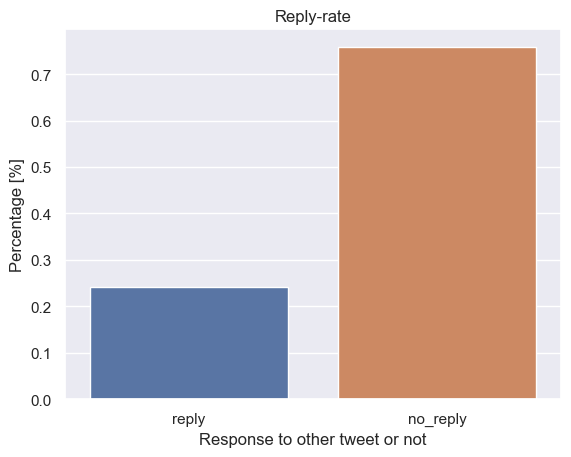

In [158]:
ax = sns.barplot(df_response_count)
ax.set_title("Reply-rate")
ax.set_xlabel('Response to other tweet or not')
ax.set_ylabel('Percentage [%]')

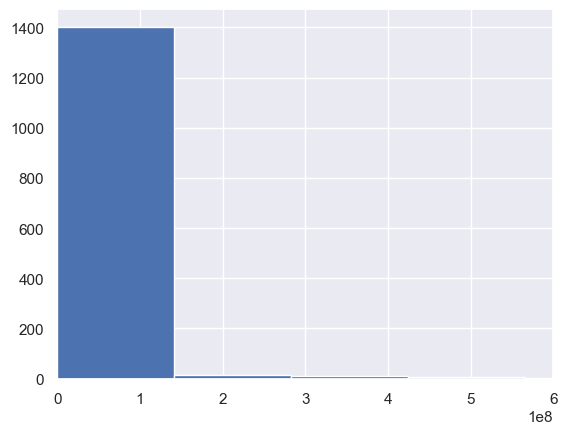

In [159]:
plt.hist(respone_list)
plt.xlim((0, 6e8))
plt.show() 

In [1]:
plt.hist(respone_list, bins=5000)
plt.xlim((0, 10e6))
plt.title('Number of tweets over reply time')
plt.xlabel('Reply time (ms)')
plt.ylabel('numbe rof tweets (count)')
plt.show() 

NameError: name 'plt' is not defined

In [161]:
df_clean = df_data.drop('tweet_sentiment', axis=1)
df_clean.head()

,mentions,response_time,tweet_length
0,[108560489],0,111
1,[1001079229864398851],0,87
2,"[25062036, 38676903, 2335437045]",99565,71
3,"[2232016410, 22536055]",638781,94
4,[34713362],0,139


In [162]:
# Detect the users 
# (what airline is it? Or is it not an airline?)
df_clean['user_mentions'] = 'Null'
df_clean['airline'] = 'Null'
df_clean['mention_count'] = 'Null'

# For every list of mentions per tweet
for i, mentions in enumerate(df_clean['mentions']):
    # Count the number of user_mentions
    df_clean['mention_count'][i] = len(mentions)

    # Detect the airline
    mentions_list = []
    airline = 'no_airline'
    # check for every mention
    added = False
    for mention in mentions:
        # if the mention is an airline
        added = False
        for key in airlineIDs:
            if int(mention) == int(airlineIDs[key]):
                mentions_list.append(key)
                airline = key
                added = True
                continue
        if added == False:
            mentions_list.append('no_airline')
    df_clean['user_mentions'][i] = mentions_list
    df_clean['airline'][i] = airline

df_user = df_clean.drop(['mentions', 'user_mentions'], axis=1)

In [163]:
df_user.head()

,response_time,tweet_length,airline,mention_count
0,0,111,no_airline,1
1,0,87,no_airline,1
2,99565,71,easyJet,3
3,638781,94,AmericanAir,2
4,0,139,no_airline,1


In [164]:
df_time_mention = df_user.drop('airline', axis=1)
df_time_mention.head()

,response_time,tweet_length,mention_count
0,0,111,1
1,0,87,1
2,99565,71,3
3,638781,94,2
4,0,139,1


In [165]:
df_time_mention['mention_count'].describe()

count     6000
unique      12
top          1
freq      3425
Name: mention_count, dtype: int64

In [166]:
df_time_mention_percent = df_time_mention.groupby(['mention_count'])['response_time'].agg(['count'])
df_time_mention_percent.head()

,count
mention_count,
0,604
1,3425
2,1143
3,474
4,164


In [167]:
df_time_mention_percent = (df_time_mention_percent['count']/1000).to_frame()
df_time_mention_percent.head()

,count
mention_count,
0,0.604
1,3.425
2,1.143
3,0.474
4,0.164


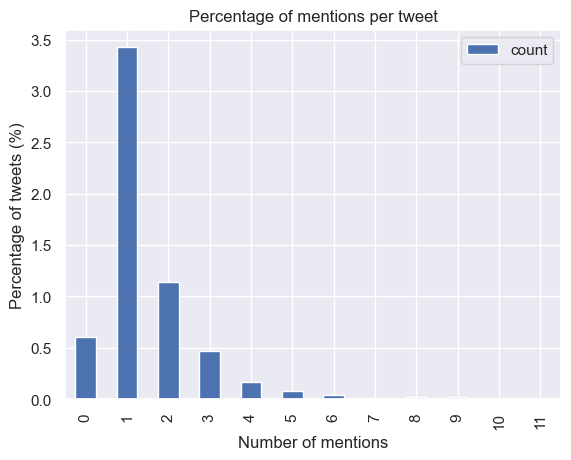

In [168]:
ax = df_time_mention_percent.plot(kind='bar', ) 
ax.set_xlabel('Number of mentions')
ax.set_ylabel('Percentage of tweets (%)')
ax.set_title('Percentage of mentions per tweet');

In [169]:
df_time_mention2 = df_time_mention.groupby(['mention_count']).agg({'response_time':['mean','std']})
df_time_mention2
#df_user_grouped_mention_time.head()

response_time              
                       mean           std
mention_count                            
0              1.135168e+06  1.921073e+07
1              3.728366e+06  3.758637e+07
2              1.141156e+07  8.308457e+07
3              1.066518e+07  5.468926e+07
4              1.682557e+07  8.645803e+07
5              1.314935e+07  5.533996e+07
6              1.505146e+07  7.987336e+07
7              8.950321e+06  2.303922e+07
8              1.197520e+07  2.409978e+07
9              4.649863e+07  1.344603e+08
10             1.930633e+06  3.825135e+06
11             0.000000e+00  0.000000e+00

In [170]:
df_time_mention3 = (df_time_mention2['response_time']['mean'] / (1000 * 60 * 60)).to_frame()
df_time_mention3.head()


,mean
mention_count,
0,0.315325
1,1.035657
2,3.169877
3,2.962551
4,4.673769


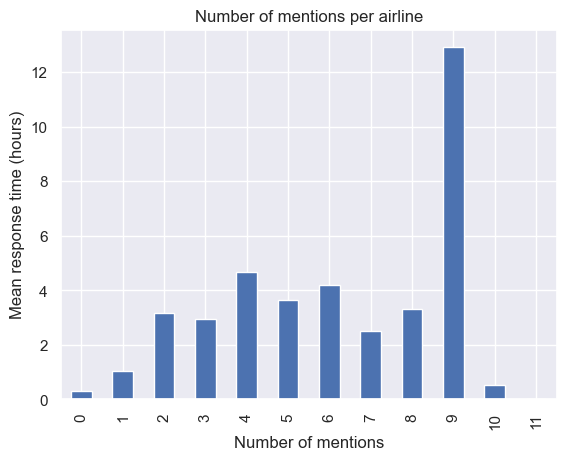

In [171]:
ax = df_time_mention3['mean'].plot(kind='bar', ) 
ax.set_xlabel('Number of mentions')
ax.set_ylabel('Mean response time (hours)')
ax.set_title('Number of mentions per airline');

In [172]:
df_user.head()

,response_time,tweet_length,airline,mention_count
0,0,111,no_airline,1
1,0,87,no_airline,1
2,99565,71,easyJet,3
3,638781,94,AmericanAir,2
4,0,139,no_airline,1


In [173]:
df_user_grouped = df_user.groupby(['airline'])[['mention_count']].mean()
df_user_grouped.head()

,mention_count
airline,
AirBerlin,3.000000
AirFrance,2.746032
AmericanAir,1.933532
BritishAirways,2.218798
EtihadAirways,2.727273


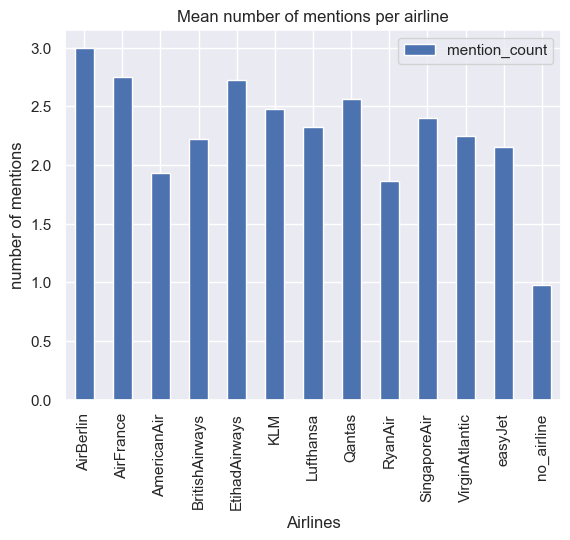

In [174]:
ax = df_user_grouped.plot(kind='bar', stacked=True, ) 
ax.set_xlabel('Airlines')
ax.set_ylabel('number of mentions')
ax.set_title('Mean number of mentions per airline');

In [175]:
df_user.head()

,response_time,tweet_length,airline,mention_count
0,0,111,no_airline,1
1,0,87,no_airline,1
2,99565,71,easyJet,3
3,638781,94,AmericanAir,2
4,0,139,no_airline,1


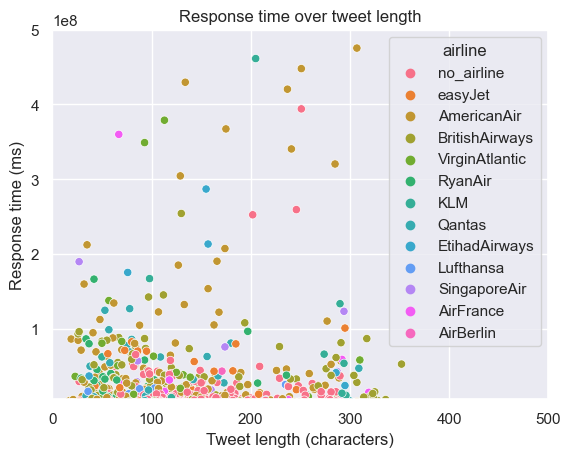

In [176]:
ax = sns.scatterplot(df_user, x='tweet_length', y='response_time', hue='airline')
ax.set_ylim(5999999, 500000000)
ax.set_xlim(0, 500)

ax.set_xlabel('Tweet length (characters)')
ax.set_ylabel('Response time (ms)')
ax.set_title('Response time over tweet length');

The positive correlation could be due to re-tweeting one's own tweet to get more words.
Regression model removing the ≈ word limit.

In [177]:
df_user.head()

,response_time,tweet_length,airline,mention_count
0,0,111,no_airline,1
1,0,87,no_airline,1
2,99565,71,easyJet,3
3,638781,94,AmericanAir,2
4,0,139,no_airline,1


In [178]:
df_user_time_clean = pd.DataFrame()

for i in range(0, len(df_user.index)):
    if df_user.loc[i, 'response_time'] != 0:
        dict = {'response_time': (df_user.loc[i, 'response_time'])/(1000*60*60), 'airline': df_user.loc[i, 'airline']}
        df_dict = pd.DataFrame([dict])
        df_user_time_clean = pd.concat([df_user_time_clean, df_dict], ignore_index=True)
        
df_user_time_clean.head()
        

,response_time,airline
0,0.027657,easyJet
1,0.177439,AmericanAir
2,0.059014,VirginAtlantic
3,0.180920,no_airline
4,0.240435,no_airline


In [179]:
df_user_grouped_time = df_user_time_clean.groupby(['airline'])[['response_time']].mean()
df_user_grouped_time.head()

,response_time
airline,
AirBerlin,12.079810
AirFrance,7.022621
AmericanAir,8.957462
BritishAirways,15.386661
EtihadAirways,16.012951


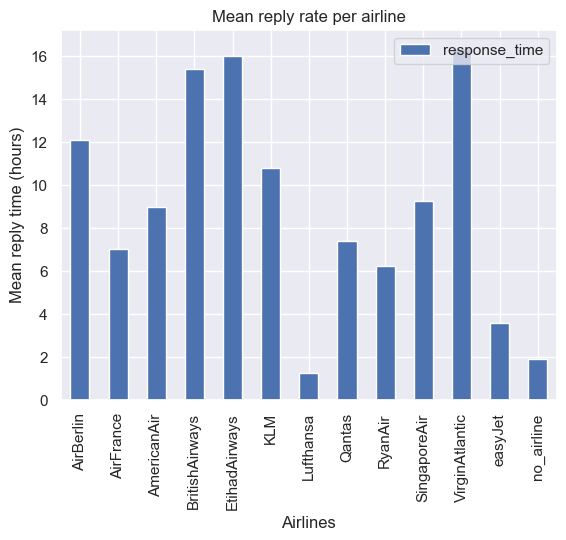

In [180]:
ax = df_user_grouped_time.plot(kind='bar', stacked=True, ) 
ax.set_xlabel('Airlines')
ax.set_ylabel('Mean reply time (hours)')
ax.set_title('Mean reply rate per airline');

In [181]:
df_user_grouped_time

,response_time
airline,
AirBerlin,12.079810
AirFrance,7.022621
AmericanAir,8.957462
BritishAirways,15.386661
EtihadAirways,16.012951
KLM,10.804508
Lufthansa,1.241481
Qantas,7.367659
RyanAir,6.203383


In [182]:

other_airlines_response_time = 0

for key in airlineIDs:
    # If ID and airline ID match:            
    if key == 'AirBerlin' or key == 'AirBerlin_assist':
        continue
    if key != 'AmericanAir' or key != 'BritishAirways':
        other_airlines_response_time = (other_airlines_response_time + df_user_grouped_time.loc[key, 'response_time'])

other_airlines_response_time = other_airlines_response_time / len(df_user_grouped_time.index)

competitor_df = pd.DataFrame(columns=['airline', 'response_time'])
competitor_df.loc[1, 'airline'] = 'AmericanAir'
competitor_df.loc[2, 'airline'] = 'BritishAirways'
competitor_df.loc[3, 'airline'] = 'OtherAirline'

competitor_df.loc[1, 'response_time'] = df_user_grouped_time.loc['AmericanAir', 'response_time']
competitor_df.loc[2, 'response_time'] = df_user_grouped_time.loc['BritishAirways', 'response_time']
competitor_df.loc[3, 'response_time'] = other_airlines_response_time



competitor_df.head()


,airline,response_time
1,AmericanAir,8.957462
2,BritishAirways,15.386661
3,OtherAirline,7.861947


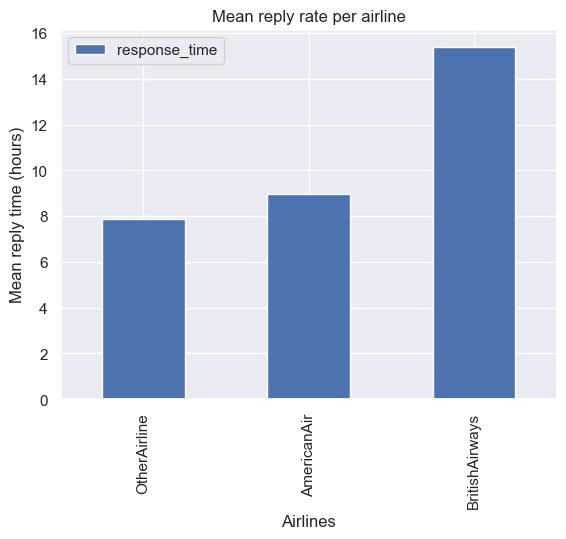

In [183]:
competitor_sorted = competitor_df.sort_values('response_time')

ax = competitor_sorted.plot(kind='bar', x='airline', y='response_time',) 
ax.set_xlabel('Airlines')
ax.set_ylabel('Mean reply time (hours)')
ax.set_title('Mean reply rate per airline');

In [185]:
df_data.head()

,mentions,tweet_sentiment,response_time,tweet_length
0,[108560489],0.980002,0,111
1,[1001079229864398851],-0.909135,0,87
2,"[25062036, 38676903, 2335437045]",-0.894911,99565,71
3,"[2232016410, 22536055]",-0.059671,638781,94
4,[34713362],0.460080,0,139


In [10]:
df_sentiment = df_data[['tweet_sentiment', 'response_time']]
df_sentiment.head()

,tweet_sentiment,response_time
0,0.027474,0
1,-0.619772,0
2,-0.227704,2567751
3,-0.909135,0
4,-0.329924,154468


<Axes: xlabel='tweet_sentiment', ylabel='response_time'>

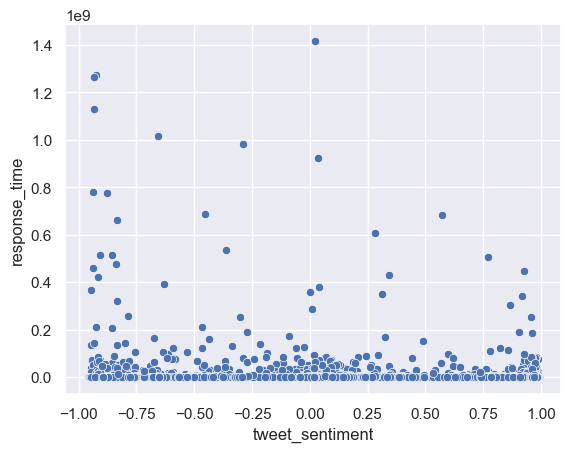

In [191]:
sns.scatterplot(df_sentiment, x='tweet_sentiment', y='response_time')

In [11]:
df_sentiment.head()

,tweet_sentiment,response_time
0,0.027474,0
1,-0.619772,0
2,-0.227704,2567751
3,-0.909135,0
4,-0.329924,154468


In [25]:
6 in range(0, 7)

True

In [23]:
print(range(-1, -0.75))

TypeError: 'float' object cannot be interpreted as an integer

In [62]:
df_sentiment_clean = pd.DataFrame(columns =['tweet_sentiment', 'response_time'])

for i in range(0, len(df_sentiment.index)):
    if df_sentiment.loc[i, 'response_time'] != 0:
        df_sentiment_clean.loc[i, 'response_time'] = df_sentiment.loc[i, 'response_time']
        df_sentiment_clean.loc[i, 'tweet_sentiment'] = df_sentiment.loc[i, 'tweet_sentiment']

df_sentiment_clean = df_sentiment_clean.reset_index()
df_sentiment_clean.head()

,index,tweet_sentiment,response_time
0,2,-0.227704,2567751
1,4,-0.329924,154468
2,5,0.139068,4307231
3,6,-0.09511,145212
4,7,0.978564,254696


In [63]:
df_sentiment_clean.head()

,index,tweet_sentiment,response_time
0,2,-0.227704,2567751
1,4,-0.329924,154468
2,5,0.139068,4307231
3,6,-0.09511,145212
4,7,0.978564,254696


In [64]:
sentiment_labels = ['strong_neg', 'neg', 'medium_neg', 'mild_neg', 'mild_pos', 'medium_pos', 'pos', 'strong_pos']
sentiment_bins = [-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]

for i in range(0, len(df_sentiment_clean.index)):
    for j in range(0, len(sentiment_bins)-1):
        sentiment = float(df_sentiment_clean.loc[i, 'tweet_sentiment'])
        if sentiment > sentiment_bins[j] and sentiment < sentiment_bins[j+1]:
            df_sentiment_clean.loc[i, 'tweet_sentiment'] = sentiment_labels[j]
            break


df_sentiment_clean.head()

,index,tweet_sentiment,response_time
0,2,mild_neg,2567751
1,4,medium_neg,154468
2,5,mild_pos,4307231
3,6,mild_neg,145212
4,7,strong_pos,254696


In [68]:
df_sentiment_clean.head()

,index,tweet_sentiment,response_time
0,2,mild_neg,2567751
1,4,medium_neg,154468
2,5,mild_pos,4307231
3,6,mild_neg,145212
4,7,strong_pos,254696


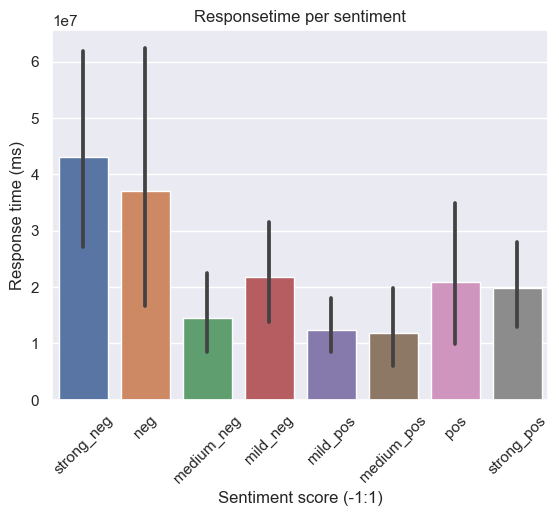

In [74]:
ax = sns.barplot(data=df_sentiment_clean, x='tweet_sentiment', y='response_time', order = sentiment_labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xlabel('Sentiment score (-1:1)')
ax.set_ylabel('Response time (ms)')
ax.set_title('Response time per sentiment');


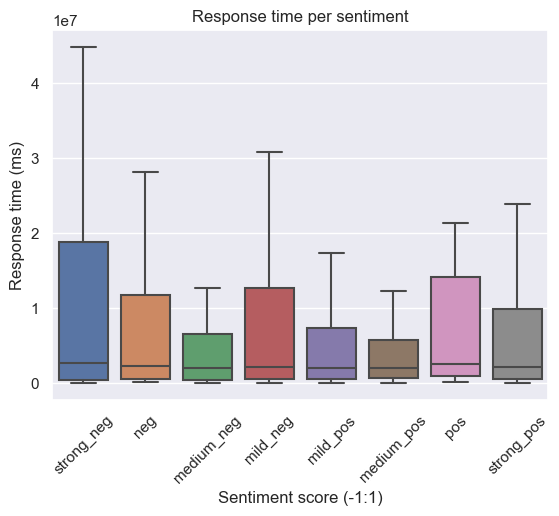

In [76]:
ax = sns.boxplot(data=df_sentiment_clean, x='tweet_sentiment', y='response_time', order = sentiment_labels, showfliers=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xlabel('Sentiment score (-1:1)')
ax.set_ylabel('Response time (ms)')
ax.set_title('Response time per sentiment');


In [26]:
import pandas as pd

df_sentiment_binned = pd.DataFrame(columns= ['tweet_sentiment', 'reply_time'])
sentiment_bins = ['strong_neg', 'neg', 'medium_neg', 'mild_neg', 'mild_pos', 'medium_pos', 'pos', 'strong_pos']

for i in range(0, len(df_sentiment.index)):
    for j, interval in enumerate[range(-1, -0.75), range(-0.75, -0.5), range(-0.5, -0.25), range(-0.25, 0), range(0, 0.25), range(0.25, 0.5), range(0.5, 0.75), range(0.75, 1)]:
        if df_sentiment.loc[i, 'tweet_sentiment'] in interval:
            df_sentiment_binned.loc[i, 'tweet_sentiment'] = sentiment_bins[i]
        else:
            df_sentiment_binned.loc[i, 'tweet_sentiment'] = df_sentiment.loc[i, 'tweet_sentiment']

df_sentiment_binned['reply_time'] = df_sentiment['reply_time']
df_sentiment_binned.head()

TypeError: 'float' object cannot be interpreted as an integer

In [ ]:




out = pd.cut(df_sentiment['tweet_sentiment'], bins=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1], include_lowest=True)
ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(6,4))

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

ax.set_xlabel('Reply time over sentiment')
ax.set_ylabel('Sum reply time (hours)')
ax.set_title('Sum of reply time per sentiment');
plt.show()

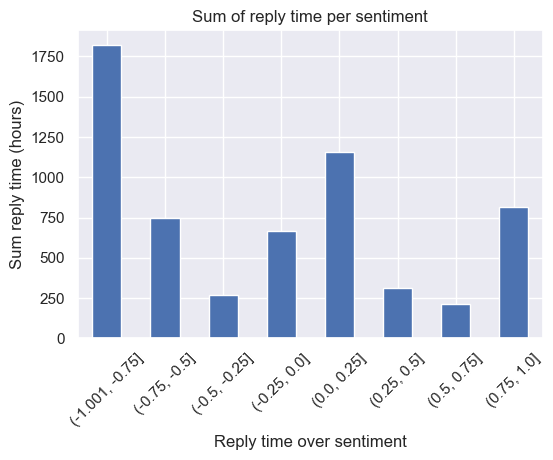

In [17]:
import pandas as pd

out = pd.cut(df_sentiment['tweet_sentiment'], bins=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1], include_lowest=True)
ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(6,4))

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

ax.set_xlabel('Reply time over sentiment')
ax.set_ylabel('Sum reply time (hours)')
ax.set_title('Sum of reply time per sentiment');
plt.show()

In [19]:
out = pd.cut(df_sentiment['tweet_sentiment'], bins=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1], include_lowest=True)
out.head()

0        (0.0, 0.25]
1      (-0.75, -0.5]
2       (-0.25, 0.0]
3    (-1.001, -0.75]
4      (-0.5, -0.25]
Name: tweet_sentiment, dtype: category
Categories (8, interval[float64, right]): [(-1.001, -0.75] < (-0.75, -0.5] < (-0.5, -0.25] < (-0.25, 0.0] < (0.0, 0.25] < (0.25, 0.5] < (0.5, 0.75] < (0.75, 1.0]]

In [ ]:
for i in range(0, len(df_sentiment.index)):
    if df_sentiment.loc[i, 'tweet_sentiment']

In [20]:


df_sentiment_group = df_sentiment.groupby(['tweet_sentiment', 'response_time'])['response_time'].agg(['count'])
df_sentiment_group.head()

,,count
tweet_sentiment,response_time,
-0.959638,0,1
-0.958832,0,1
-0.958422,0,1
-0.956255,0,1
-0.955174,0,1


In [184]:
ax = df_user_grouped_time.plot(kind='box', x='airline', y='response_time') 
ax.set_xlabel('Airlines')
ax.set_ylabel('Mean reply time (hours)')
ax.set_title('Mean reply rate per airline');

KeyError: 'airline'

In [ ]:
df_user_time_clean.head()

,response_time,airline
0,8.347461,BritishAirways
1,0.056669,no_airline
2,1.853737,no_airline
3,0.100266,no_airline
4,0.815347,no_airline


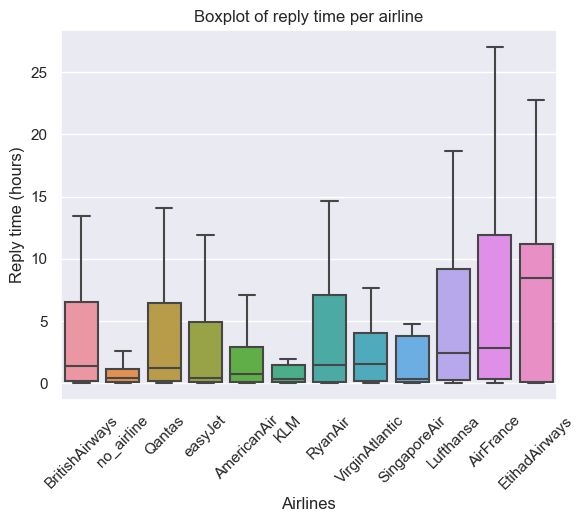

In [ ]:
ax = sns.boxplot(data=df_user_time_clean, x='airline', y='response_time', showfliers=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xlabel('Airlines')
ax.set_ylabel('Reply time (hours)')
ax.set_title('Boxplot of reply time per airline');


In [ ]:
for i in range(0, len(df_user_time_clean)):
    print(df_user_time_clean.loc[i, 'airline'])
    if df_user_time_clean.loc[i, 'airline'] == 'BritishAirways' or df_user_time_clean.loc[i, 'airline'] == 'AmericanAir':
        pass
    else:
        df_user_time_clean.loc[i, 'airline'] = 'OtherAirline'

df_user_time_clean.head()



BritishAirways
no_airline
no_airline
no_airline
no_airline
Qantas
easyJet
AmericanAir
BritishAirways
AmericanAir
KLM
Qantas
RyanAir
AmericanAir
easyJet
Qantas
BritishAirways
BritishAirways
AmericanAir
AmericanAir
RyanAir
BritishAirways
BritishAirways
no_airline
no_airline
AmericanAir
BritishAirways
Qantas
easyJet
Qantas
no_airline
no_airline
BritishAirways
VirginAtlantic
no_airline
AmericanAir
AmericanAir
AmericanAir
no_airline
SingaporeAir
BritishAirways
no_airline
AmericanAir
no_airline
AmericanAir
no_airline
no_airline
no_airline
AmericanAir
RyanAir
BritishAirways
no_airline
easyJet
VirginAtlantic
no_airline
AmericanAir
BritishAirways
BritishAirways
no_airline
easyJet
AmericanAir
no_airline
AmericanAir
RyanAir
Lufthansa
BritishAirways
no_airline
AmericanAir
AmericanAir
no_airline
AirFrance
AmericanAir
AmericanAir
easyJet
RyanAir
BritishAirways
no_airline
AmericanAir
AmericanAir
AmericanAir
AmericanAir
AmericanAir
no_airline
BritishAirways
Qantas
AmericanAir
no_airline
no_airline
no_

,response_time,airline
0,8.347461,BritishAirways
1,0.056669,OtherAirline
2,1.853737,OtherAirline
3,0.100266,OtherAirline
4,0.815347,OtherAirline


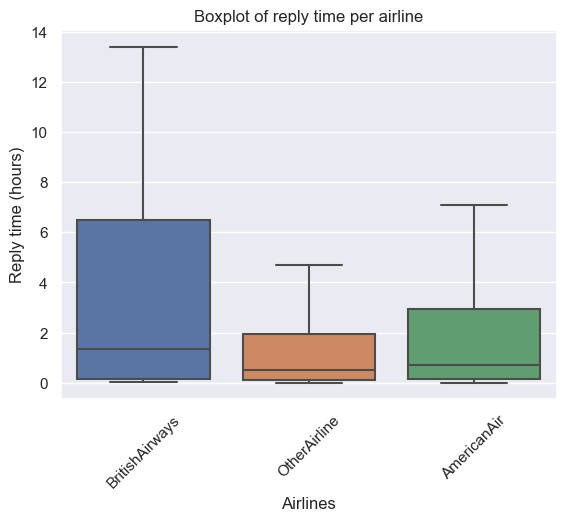

In [ ]:
ax = sns.boxplot(data=df_user_time_clean, x='airline', y='response_time', showfliers=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xlabel('Airlines')
ax.set_ylabel('Reply time (hours)')
ax.set_title('Boxplot of reply time per airline');

In [ ]:
df_data

,response_time,airline
0,4437957,no_airline


In [ ]:
df_time_clean = pd.DataFrame()

for i in range(0, len(df_data.index)):
    if df_data.loc[i, 'response_time'] != 0:
        dict = {'response_time': (df_data.loc[i, 'response_time'])/(1000*60*60), 'airline': df_data.loc[i, 'airline']}
        df_dict = pd.DataFrame([dict])
        df_user_time_clean = pd.concat([df_time_clean, df_dict], ignore_index=True)
        
df_time_clean.head()

""


In [ ]:
df_data.head()

,response_time,airline
0,4437957,no_airline
